In [1]:
import os
from pathlib import Path
from ultralytics import YOLO
from PIL import Image
import shutil
import pandas as pd
from source import image_id_converter as img_idc
from source import sort_img_files as sif
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

In [2]:
import ollama
import json
import re
import pickle

In [3]:
os.getcwd()

'/storage/homefs/sh98e089'

# Using LLM (mini-CPM) for image analysis

### Define Functions:

In [4]:
import os
from PIL import Image



def convert_tif_to_jpg(source_folder, destination_folder, quality=85):
    """
    Convert .tif files to .jpg format and move copies to destination folder.
    Original .tif files remain in source folder.
    
    Args:
        source_folder (str): Path to folder containing .tif files
        destination_folder (str): Path to destination folder for .jpg files
        quality (int): JPEG quality (1-100, default 85)
    """
    # Create destination folder if it doesn't exist
    os.makedirs(destination_folder, exist_ok=True)
    
    converted_files = []
    
    # Process all .tif files in source folder
    for filename in os.listdir(source_folder):
        if filename.lower().endswith(('.tif', '.tiff')):
            source_path = os.path.join(source_folder, filename)
            
            # Create new filename with .jpg extension
            base_name = os.path.splitext(filename)[0]
            jpg_filename = f"{base_name}.jpg"
            destination_path = os.path.join(destination_folder, jpg_filename)
            
            try:
                # Open and convert image
                with Image.open(source_path) as img:
                    # Convert to RGB if necessary (TIFF might be in different modes)
                    if img.mode != 'RGB':
                        img = img.convert('RGB')
                    
                    # Save as JPEG in destination folder
                    img.save(destination_path, 'JPEG', quality=quality, optimize=True)
                
                converted_files.append(jpg_filename)
                print(f"Converted: {filename} -> {jpg_filename}")
                
            except Exception as e:
                print(f"Error converting {filename}: {str(e)}")
    
    print(f"Successfully converted {len(converted_files)} files")
    return converted_files

# Example usage:
# convert_tif_to_jpg("/path/to/source", "/path/to/destination")

In [5]:
from PIL import Image
import os
from pathlib import Path

def convert_image_if_needed(image_path):
    """Convert TIFF (and other unsupported formats) to JPG."""
    path = Path(image_path)
    
    if path.suffix.lower() in ['.tif', '.tiff']:
        try:
            img = Image.open(path)
            if img.mode != 'RGB':
                img = img.convert('RGB')
            
            # Build new path manually
            jpg_path = path.parent / f"{path.stem}_converted.jpg"
            
            img.save(jpg_path, 'JPEG', quality=95)
            print(f"Converted {path} to {jpg_path}")
            return str(jpg_path)
        except Exception as e:
            print(f"Error converting {path}: {e}")
            return None
    else:
        return str(path)


def call_ollama_model(image_path, prompt):
    """Make the API call to Ollama."""
    # Convert image if needed
    processed_path = convert_image_if_needed(image_path)
    if processed_path is None:
        raise ValueError(f"Could not process image: {image_path}")
    
    response = ollama.chat(
        #model="minicpm-v",
        model="llama3.2-vision:90b",
        messages=[{
            'role': 'user', 
            'content': prompt,
            'images': [processed_path]
        }],
        options={
        'temperature': 0.1,  # Lower = more deterministic (0.0 to 1.0)
        'seed': 42           # Fixed seed for reproducibility
    }
    )
    return response['message']['content']

In [6]:
def create_analysis_prompt():
    """Create the structured prompt for image analysis."""
    return """
    Analyze this image and return ONLY a Python dictionary in exactly this format:
    
    {
        'image_is_photography': X,  # True if the image is a photography, False otherwise
        'additional_comments': '' # Any additional observations or empty string if none
    }
    
    Replace X with True (image is a photography) or False (image is not a photography).
    Return ONLY the dictionary, no other text.
    Your answer MUST have the exact structue of the dictionary described above (all keys MUST be present). 
    If you cannot answer the question in the way implied by this structure, enter 'None' as value and offer 
    your answer and explanations under 'additional_comments'.
    """

In [7]:
type(True)

bool

In [8]:
import ast
import re

def parse_response_to_dict(response_text):
    """Parse the model response into a Python dictionary."""
    try:
        # First try to find dictionary in code blocks
        code_block_match = re.search(r'```(?:python)?\s*(\{.*?\})\s*```', response_text, re.DOTALL)
        if code_block_match:
            dict_str = code_block_match.group(1)
        else:
            # Fallback to finding any dictionary pattern
            dict_match = re.search(r'\{.*\}', response_text, re.DOTALL)
            if dict_match:
                dict_str = dict_match.group()
            else:
                return False, None
        
        # Clean up the dictionary string
        dict_str = dict_str.replace('\\_', '_')
        dict_str = dict_str.strip()
        
        # Parse the dictionary
        result_dict = ast.literal_eval(dict_str)
        return True, result_dict
        
    except Exception as e:
        return False, None

In [9]:
def analyze_image_structured(image_path):
    """Main function that orchestrates the image analysis."""
    # Define prompt for LLM model:
    prompt = create_analysis_prompt()
    # Ask LLM to analyse image, by calling the model and providing 
    # the defined prompt: 
    response_text = call_ollama_model(image_path, prompt)
    # Parse response text, i.e. find dictionary of expected structure
    # in the response text:
    success, result_dict = parse_response_to_dict(response_text)
    
    if success:
        return result_dict
    else:
        # Save response text in dictionary paired with key "raw_response"
        # if parsing the response text fails:
        llm_response = {"raw_response": response_text}
        return llm_response

In [10]:
def add_pred_values(idx, labels_results, columns, values_to_add):
    selection_bools = labels_results.image_id == inspection_idx
    
    labels_results.loc[selection_bools, columns] = values_to_add

In [11]:
def extract_vals_from_response_dict(img_ids, image_descr, keys_list_expected, response_variable): 
   #img_type = []
   response_values = []
   #with_person = []
   #with_church = []
   
   # Make empty list to store responses that cannot be parsed
   # due to faulty structure for closer inspection: 
   img_ids_closer_inspection = []
   
   iter_count = 0
   
   # Loop through image ids:
   for img_id in img_ids:
   
       # Get response from LLM for image id in question:
       img_pred = image_descr[img_id]
   
       # Get keys from response dictionary:
       keys_list = list(img_pred.keys())
   
       # Check if structure and keys of response match expectation:
       dict_struct_condition = (type(img_pred) == dict)
       keys_condition = (keys_list_expected == keys_list)
   
       # Check if response key 
       raw_key_condition = keys_list == ['raw_response']
       
       # If the llm response corresponds to the expected
       # structure, get response values as planned:
       if dict_struct_condition and keys_condition:
           
           bool_value = img_pred[response_variable]
   
           if bool_value:
               int_value = int(1)
           else:
               int_value = int(0)
   
           response_values.append(int_value)
           
       # If llm response does not correspond to the expected 
       # structure but does have the 'raw_response' key
       # try to identify a dictionary inside the response text
       # and try to parse this dictionary as planned:
       elif dict_struct_condition and raw_key_condition:
           print('\n')
           print('raw_repsonse_dict:')
           print(img_id)
           print(dict_struct_condition)
           print(raw_key_condition)
   
           response_text = img_pred['raw_response']
   
           start_indices = [i for i, char in enumerate(response_text) if char == '{']
           start_idx = start_indices[0]
           
           end_indices = [i for i, char in enumerate(response_text) if char == '}']
           end_idx = end_indices[0]
   
           dict_in_text = response_text[start_idx:end_idx+1]
   
           success_bool, img_pred = parse_response_to_dict(dict_in_text)
           print('success_bool:')
           print(success_bool)
   
           # If a dictionary is found and parsed successfully
           # get response values as planned:
           if success_bool:
               print(type(img_pred))
               print(img_pred.keys())
               
               bool_value = img_pred[response_variable]
       
               if bool_value:
                   int_value = int(1)
               else:
                   int_value = int(0)
               
               response_values.append(int_value)
               
           else:
               # If dictionary is not found or not successfully
               # parsed, add the image in question to the list
               # of images for closer (visual) inspection:
               print('parse unsuccessful')
               print(img_id)
               img_ids_closer_inspection.append(img_id)
               response_values.append(None)
   
       # If the llm response does not have the expected struture
       # and no 'raw_response' key is found, add the image in 
       # question to the list of images for closer (visual)
       # inspection:
       else:
           print('\n')
           print('no structure at all:')
           print(img_id)
           img_ids_closer_inspection.append(img_id)
           response_values.append(None)
           
       
       iter_count += 1
   return img_ids, response_values, img_ids_closer_inspection

In [12]:
# More comprehensive check including empty strings and whitespace
def has_missing_comprehensive(df):
   # Standard missing values
   has_standard_missing = df.isnull().any().any()
   
   # Empty strings and whitespace-only strings
   has_empty_strings = False
   for col in df.select_dtypes(include=['object']):
       if (df[col].astype(str).str.strip() == '').any():
           has_empty_strings = True
           break
   
   return has_standard_missing or has_empty_strings

In [13]:
def get_classification_subsets_metrics(labels_results, var_name, pred_var_name):
    positive_bools = labels_results[var_name] == 1
    negative_bools = labels_results[var_name] == 0
    positive_pred_bools = labels_results[pred_var_name] == 1
    negative_pred_bools = labels_results[pred_var_name] == 0
    
    positives = labels_results[positive_bools]
    negatives = labels_results[negative_bools]
    true_positives = labels_results[positive_bools & positive_pred_bools]
    true_negatives = labels_results[negative_bools & negative_pred_bools]
    
    false_negatives = labels_results[positive_bools & negative_pred_bools]
    false_positives = labels_results[negative_bools & positive_pred_bools]

    sensitivity = true_positives.shape[0] / positives.shape[0]
    print('sensitivity:')
    print(sensitivity)
    
    specificity = true_negatives.shape[0] / negatives.shape[0]
    print('specificity:')
    print(specificity)

    subsets_and_metrics = (positives, negatives, true_positives, true_negatives, 
                           false_negatives, false_positives, sensitivity, specificity)
    
    return subsets_and_metrics

In [14]:
def plot_conf_matrix(labels_results, label, prediction, cases):
    true_positives, false_positives, true_negatives, false_negatives, positives, negatives = cases
    # Calculate confusion matrix
    cm = confusion_matrix(labels_results[label], labels_results[prediction])
    
    number_true_positives = true_positives.shape[0]
    number_false_positives = false_positives.shape[0]
    number_true_negatives = true_negatives.shape[0]
    number_false_negatives = false_negatives.shape[0]
    
    sensitivity = number_true_positives / positives.shape[0]
    specificity = number_true_negatives / negatives.shape[0]
   # if (number_true_positives + number_false_positives) > 0:
   #     precision = number_true_positives / (number_true_positives + number_false_positives)
   #     f1_score = 2 * (precision * sensitivity) / (precision + sensitivity)
   # else:
   #     precision = None
   #     f1_score = None
   # if positives.shape[0] > 0:
   #     miss_rate = number_false_negatives / positives.shape[0]
   # else:
   #     miss_rate = None
    
    print("Confusion Matrix:")
    
    plt.figure(figsize=(8,6))
    confusion_matrix_data = [[number_true_negatives, number_false_positives], 
                              [number_false_negatives, number_true_positives]]
    sns.heatmap(confusion_matrix_data, annot=True, fmt='d', 
                xticklabels=['Predicted Negative', 'Predicted Positive'], 
                yticklabels=['Actual Negative', 'Actual Positive'])
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()
    
    print(f'True Positives: {number_true_positives}')
    print(f'False Positives: {number_false_positives}')
    print(f'True Negatives: {number_true_negatives}')
    print(f'False Negatives: {number_false_negatives}')
    print(f'\nSensitivity (Recall): {sensitivity:.4f}')
    print(f'Specificity: {specificity:.4f}')
    #if precision is not None:
    #    print(f'Precision: {precision:.4f}')
    #    print(f'Miss Rate (False Negative Rate): {miss_rate:.4f}')
    #    print(f'F1 Score: {f1_score:.4f}')

In [15]:
def save_conf_matrix_tag(labels_results, label, prediction, cases, filename_tag):
    true_positives, false_positives, true_negatives, false_negatives, positives, negatives = cases
    # Calculate confusion matrix
    cm = confusion_matrix(labels_results[label], labels_results[prediction])
    
    number_true_positives = true_positives.shape[0]
    number_false_positives = false_positives.shape[0]
    number_true_negatives = true_negatives.shape[0]
    number_false_negatives = false_negatives.shape[0]
    
    sensitivity = number_true_positives / positives.shape[0]
    specificity = number_true_negatives / negatives.shape[0]
    
   # if (number_true_positives + number_false_positives) > 0:
   #     precision = number_true_positives / (number_true_positives + number_false_positives)
   #     f1_score = 2 * (precision * sensitivity) / (precision + sensitivity)
   # else:
   #     precision = None
   #     f1_score = None
        
   # if positives.shape[0] > 0:
   #     miss_rate = number_false_negatives / positives.shape[0]
   # else:
   #     miss_rate = None
    
    
    plt.figure(figsize=(15,8))
    gs = plt.GridSpec(1, 2, width_ratios=[2, 1])
    
    plt.subplot(gs[0])
    confusion_matrix_data = [[number_true_negatives, number_false_positives], 
                             [number_false_negatives, number_true_positives]]
    heatmap = sns.heatmap(confusion_matrix_data, annot=True, fmt='d', 
               xticklabels=['Predicted Negative', 'Predicted Positive'], 
               yticklabels=['Actual Negative', 'Actual Positive'],
               cbar_kws={'label': 'Number of Instances'})
    plt.title('Confusion Matrix')
    
    plt.subplot(gs[1])
    plt.axis('off')
    metrics_text = (f'Performance Metrics:\n\n'
                       f'True Positives: {number_true_positives}\n'
                       f'False Positives: {number_false_positives}\n'
                       f'True Negatives: {number_true_negatives}\n'
                       f'False Negatives: {number_false_negatives}\n\n'
                       f'Sensitivity: {sensitivity:.4f}\n'
                       f'Specificity: {specificity:.4f}\n')
        
    plt.text(0, 0.5, metrics_text, fontsize=10, 
            verticalalignment='center')
    
    plt.suptitle('Photography Detection: Confusion Matrix and Performance Metrics Based on is_photo Label as Ground Truth', fontsize=16)
    plt.tight_layout()
    filename = 'conf_matrix_metrics_' + filename_tag + '.pdf'
    output_path = data_path / filename
    plt.savefig(output_path)
    plt.close()

In [16]:
def store_duration(time_analysis_dict, time_analysis_for_df_dict, analysis_name, duration):
    time_analysis_dict[analysis_name] = {}
    time_analysis_dict[analysis_name]['duration_str'] = f"Analysis took: {duration}"
    time_analysis_dict[analysis_name]['duration_seconds'] = total_seconds
    time_analysis_dict[analysis_name]['duration_seconds_str'] = f"Analysis took: {total_seconds:.2f} seconds"
    time_analysis_dict[analysis_name]['duration_minutes'] = total_seconds/60
    time_analysis_dict[analysis_name]['duration_minutes_str'] = f"Analysis took: {total_seconds/60:.2f} minutes"
    time_analysis_dict[analysis_name]['time_stamp_start'] = timestamp_start_is_photo_analysis
    time_analysis_dict[analysis_name]['time_stamp_end'] = timestamp_end_is_photo_analysis

    time_analysis_for_df_dict['analysis_name'].append(analysis_name)
    time_analysis_for_df_dict['duration_str'].append(f"Analysis took: {duration}")
    time_analysis_for_df_dict['duration_seconds'].append(total_seconds)
    time_analysis_for_df_dict['duration_seconds_str'].append(f"Analysis took: {total_seconds:.2f} seconds")
    time_analysis_for_df_dict['duration_minutes'].append(total_seconds/60)
    time_analysis_for_df_dict['duration_minutes_str'].append(f"Analysis took: {total_seconds/60:.2f} minutes")
    

In [17]:
def analyse_giub_img_dir_llm(jpg_data_path):
    # Get time stamp:
    timestamp_start_is_photo_analysis = pd.Timestamp.now()
    
    # Get list of image files to analyse: 
    image_files = os.listdir(jpg_data_path)
    img_ids = [image_file.split('Oberland')[1].split('.')[0] for image_file in image_files]
    
    # Make empty dictionary to store results:
    image_descr = {}
    
    # Loop through images to get answers: 
    for image_file in image_files:
        image_path = jpg_data_path / image_file
        path_str = str(image_path)
        print('\n')
        print(path_str)
        parts = path_str.split('.jpg')
        img_id = parts[-2][-3:]
    
        # Analyse image, get values for each of the categorical variables specified above:
        image_description = analyze_image_structured(image_path)
        
        dict_type_bool = type(image_description) == dict
            
        print(image_description)
        image_descr[img_id] = image_description
    
    timestamp_end_is_photo_analysis = pd.Timestamp.now()

    return timestamp_start_is_photo_analysis, timestamp_end_is_photo_analysis, image_descr

### Prepare empty dictionary for time analyses and get time stamp for overall workflow duration:

In [18]:
time_analyses = {}
time_analyses_for_df = {}
time_analyses_for_df['analysis_name'] = []
time_analyses_for_df['duration_str'] = []
time_analyses_for_df['duration_seconds'] = []
time_analyses_for_df['duration_seconds_str'] = []
time_analyses_for_df['duration_minutes'] = []
time_analyses_for_df['duration_minutes_str'] = []
timestamp_start_workflow = pd.Timestamp.now()
timestamp_start_workflow

Timestamp('2025-09-25 18:39:34.494727')

### Prepare empty dictionary to store the different response dictionaries:

In [19]:
response_dictionaries = {}


### Prepare empty dictionary for cases with unstructured answers for visual inspection:

In [20]:
images_closer_inspection = {}


### Prepare empty dictionary for result dataframes:

In [21]:
results_tabular = {}

### Set paths:

In [22]:
#root_path = Path('/Users/stephanehess/Documents/CAS_AML/dias_digit_project')
#root_path = Path('/Users/stephanehess/Documents/CAS_AML/dias_digit_project/test_yolo_object_train')

project_path = Path.cwd()
root_path = (project_path / '..' / 'test_LLM_prompt_experiments').resolve()
root_path = (project_path / 'test_LLM_prompt_experiments').resolve()
#root_path = (project_path / '..' / 'test_yolo_object_train').resolve()
data_path = root_path / 'data'
tif_data_path = root_path / 'data_1'
#data_path = root_path / 'visual_genome_data_all'
jpg_data_path = root_path / 'data_jpg'
#yolo_path = root_path / 'visual_genome_yolo_all'
output_dir_not_photo = root_path / 'not_photo'
output_dir_with_person = root_path / 'with_person'
output_dir_without_person = root_path / 'without_person'



In [23]:
project_path

PosixPath('/storage/homefs/sh98e089')

In [24]:
root_path

PosixPath('/storage/homefs/sh98e089/test_LLM_prompt_experiments')

In [25]:
data_path

PosixPath('/storage/homefs/sh98e089/test_LLM_prompt_experiments/data')

In [26]:
tif_data_path

PosixPath('/storage/homefs/sh98e089/test_LLM_prompt_experiments/data_1')

### Create directories for sorting the images:

In [27]:
# Create output directories
#os.chdir(root_path/'..')
os.makedirs(data_path, exist_ok=True)
os.makedirs(tif_data_path, exist_ok=True)
os.makedirs(jpg_data_path, exist_ok=True)
os.makedirs(output_dir_not_photo, exist_ok=True)
os.makedirs(output_dir_with_person, exist_ok=True)
os.makedirs(output_dir_without_person, exist_ok=True)
#os.chdir('root_path')

### Copy and convert image files from tif_data_path to jpg_data_path:

In [28]:

source_folder = tif_data_path
destination_folder = jpg_data_path

convert_tif_to_jpg(source_folder, destination_folder, quality=100)


Error converting BernerOberland002.tif: cannot identify image file '/storage/homefs/sh98e089/test_LLM_prompt_experiments/data_1/BernerOberland002.tif'
Error converting BernerOberland023.tif: cannot identify image file '/storage/homefs/sh98e089/test_LLM_prompt_experiments/data_1/BernerOberland023.tif'
Converted: BernerOberland081.tif -> BernerOberland081.jpg
Converted: BernerOberland033.tif -> BernerOberland033.jpg
Converted: BernerOberland043.tif -> BernerOberland043.jpg
Error converting BernerOberland008.tif: cannot identify image file '/storage/homefs/sh98e089/test_LLM_prompt_experiments/data_1/BernerOberland008.tif'
Error converting BernerOberland107.tif: cannot identify image file '/storage/homefs/sh98e089/test_LLM_prompt_experiments/data_1/BernerOberland107.tif'
Converted: BernerOberland082.tif -> BernerOberland082.jpg
Error converting BernerOberland035.tif: cannot identify image file '/storage/homefs/sh98e089/test_LLM_prompt_experiments/data_1/BernerOberland035.tif'
Error convert

['BernerOberland081.jpg',
 'BernerOberland033.jpg',
 'BernerOberland043.jpg',
 'BernerOberland082.jpg',
 'BernerOberland015.jpg',
 'BernerOberland022.jpg']

### Load person label data (ground truth) to compare to LLM responses:

The file with_without_person.csv contains labels added by (human) visual inspection that represent the ground truth. 
 * Column with_person: whether or not any person is in the image.
 * Column recognisable: whether any person that would be recognisable to a human familiar with said person is in the image.
 * Column church: whether the image contains a church.
 * Column is_photo: whether the image is a photography or something else. (this formulation is, I guess, unprecise, as most dias can probably be called a photography of sorts (if a dia shows a painting, I assume a photograph of the painting has been taken), so, to be precise: whether or not the image is showing anything that exists in the real world or is showing a representation of anything that exists in the real world or aspects thereof.

In [29]:
label_data = pd.read_csv(data_path/'labels_mod.csv')
label_data.head()

,image_id,with_person,person_recognisable,is_photo,church
0,id001,1,1,1,0
1,id002,0,0,1,1
2,id003,0,0,1,0
3,id004,0,0,1,0
4,id005,0,0,1,0


In [30]:
# Reconvert image ids to integers (e.g. '234') as strings from the form they were saved in (e.g. 'id234' 
# to ensure string data type to deal with duck typing): 
img_ids = list(label_data.image_id)
label_data['image_id'] = img_idc.reconvert_image_ids(img_ids)
label_data.head()

,image_id,with_person,person_recognisable,is_photo,church
0,001,1,1,1,0
1,002,0,0,1,1
2,003,0,0,1,0
3,004,0,0,1,0
4,005,0,0,1,0


### The following cell is only required for the test run on the test data: 

In [31]:
# Select only rows referring to images in the smaller data set (test run):

# Make sure no .DS_Store file is included in jpg_data_path: 
import os
ds_file_path = jpg_data_path / '.DS_Store'

# Remove a specific .DS_Store file
if os.path.exists(ds_file_path):
    os.remove(ds_file_path)
    print("Removed .DS_Store")
else:
    print(".DS_Store not found")

# Get list of image files present:
image_files = os.listdir(jpg_data_path)

# Extract image ids from image file names:
img_ids = [image_file.split('Oberland')[1].split('.')[0] for image_file in image_files]
img_ids.sort()
print(img_ids)

# Select relevant rows from label_data data frame by id list: 
select_bools = [img_id in img_ids for img_id in label_data.image_id]

label_data = label_data[select_bools].copy()
label_data

.DS_Store not found
['002', '003', '008', '015', '022', '023', '033', '035', '043', '081', '082', '107']


,image_id,with_person,person_recognisable,is_photo,church
1,002,0,0,1,1
2,003,0,0,1,0
7,008,0,0,1,1
14,015,1,1,1,0
21,022,0,0,0,0
22,023,1,1,1,0
32,033,0,0,0,0
34,035,0,0,1,1
42,043,0,0,1,1
80,081,0,0,0,0


In [1]:
6

6

### Prepare variations of LLM prompt functions to test:

In [32]:
def create_analysis_prompt_basic():
    """Create the structured prompt for image analysis."""
    return """
    Analyze this image and return ONLY a Python dictionary in exactly this format:
    
    {
        'image_is_photography': X,  # True if the image is a photography, False otherwise
        'additional_comments': '' # Any additional observations or empty string if none
    }
    
    Replace X with True (image is a photography) or False (image is not a photography).
    Return ONLY the dictionary, no other text.
    Your answer MUST have the exact structue of the dictionary described above (all keys MUST be present). 
    If you cannot answer the question in the way implied by this structure, enter 'None' as value and offer 
    your answer and explanations under 'additional_comments'.
    """

In [33]:
def create_analysis_prompt_precise():
    """Create the structured prompt for image analysis."""
    return """
    Analyze this image and return ONLY a Python dictionary in exactly this format:
    
    {
        'image_of_image': X,  # True if the image is a direct representation of something, False if it is an indirect representation (i.e. a representation of a representation of something).
        'additional_comments': '' # Any additional observations or empty string if none
    }
    
    Replace X with True (direct representation) or False (indirect representation).
    A representation can represent anything that exists or aspects thereof; the represantation can be concrete or abstract. 
    The image at hand can either be such a direct representation 
    or else a representation of a representation of anything that exists or of aspects thereof (concrete or abstract). 
    In other words, you have to determine if the image is a direct (Replace X with True) or an indirect representation (Replace X with False).
    Return ONLY the dictionary, no other text.
    Your answer MUST have the exact structue of the dictionary described above (all keys MUST be present). 
    If you cannot answer the question in the way implied by this structure, enter 'None' as value and offer 
    your answer and explanations under 'additional_comments'.
    """

In [34]:
def create_analysis_prompt_intuitive():
    """Create the structured prompt for image analysis."""
    return """
    Analyze this image and return ONLY a Python dictionary in exactly this format:
    
    {
        'image_is_photography': X,  # True if the image is photography, False otherwise (e.g. if the image is a map or a painting)
        'additional_comments': '' # Any additional observations or empty string if none
    }
    
    Replace X with True (image is a photography) or False (otherwise).
    Return ONLY the dictionary, no other text.
    Your answer MUST have the exact structue of the dictionary described above (all keys MUST be present). 
    If you cannot answer the question in the way implied by this structure, enter 'None' as value and offer 
    your answer and explanations under 'additional_comments'.
    """

In [35]:
def create_analysis_prompt_alternatives():
    """Create the structured prompt for image analysis."""
    return """
    Analyze this image and return ONLY a Python dictionary in exactly this format:
    
    {
        'image_is_photography': X,  # True if the image is photography, False if image is a map, a painting, a drawing, a scheme, a statistics figure, or other.
        'additional_comments': '' # Any additional observations or empty string if none.
    }
    
    Replace X with True (image is a photography) or False (image is a map, a painting, a drawing, a scheme, a statistics figure, or other).
    Return ONLY the dictionary, no other text.
    Your answer MUST have the exact structue of the dictionary described above (all keys MUST be present). 
    If you cannot answer the question in the way implied by this structure, enter 'None' as value and offer 
    your answer and explanations under 'additional_comments'.
    """

## Identify non-photo images with basic prompt:

### Set parameters:

In [36]:
analysis_name = 'is_photo_basic_struct_minicpm'
create_analysis_prompt = create_analysis_prompt_basic

label_name = 'is_photo'
prediction_name = 'is_photo_pred'
keys_list_expected = ['image_is_photography', 'additional_comments']
response_variable = 'image_is_photography'

### Run LLM image analysis:

In [37]:
timestamp_start_is_photo_analysis, timestamp_end_is_photo_analysis, image_descr = analyse_giub_img_dir_llm(jpg_data_path)




/storage/homefs/sh98e089/test_LLM_prompt_experiments/data_jpg/BernerOberland008.jpg
{'image_is_photography': True, 'additional_comments': 'The image appears to be a black and white photograph of an old town or village, with buildings and streets visible. The presence of a clock tower and other architectural features suggests that it may be a historical or cultural site.'}


/storage/homefs/sh98e089/test_LLM_prompt_experiments/data_jpg/BernerOberland015.jpg
{'image_is_photography': True, 'additional_comments': 'The image appears to be a vintage photograph of a street scene, with people and buildings visible. The presence of a horse-drawn carriage and old-fashioned clothing suggests that the photo was taken in the late 19th or early 20th century.'}


/storage/homefs/sh98e089/test_LLM_prompt_experiments/data_jpg/BernerOberland081.jpg
{'image_is_photography': False, 'additional_comments': 'The image appears to be a map or a document, possibly a historical map of an area in Italy, given t

### Extract and store results:

86.544578
12
12
False
False
False
(12, 6)
sensitivity:
0.875
specificity:
1.0
True Positives: 7
False Positives: 0
True Negatives: 4
False Negatives: 1
Confusion Matrix:


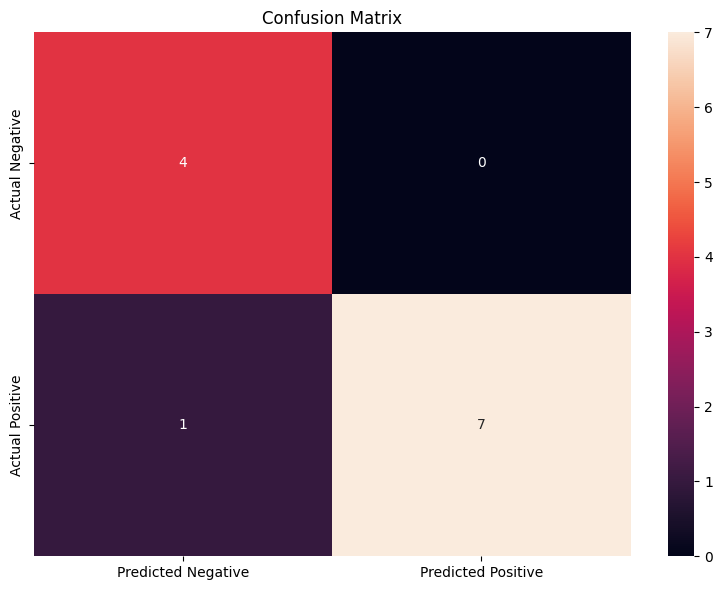

True Positives: 7
False Positives: 0
True Negatives: 4
False Negatives: 1

Sensitivity (Recall): 0.8750
Specificity: 1.0000


In [38]:
# Get duration of the LLM analysis:
duration = timestamp_end_is_photo_analysis - timestamp_start_is_photo_analysis
total_seconds = duration.total_seconds()
print(total_seconds)
store_duration(time_analyses, time_analyses_for_df, analysis_name, duration)

# Store dictionary with LLM responses:
response_dictionaries[analysis_name] = image_descr

# Extract LLM responses from dictionary:
img_ids, is_photo, img_ids_closer_inspection = \
extract_vals_from_response_dict(img_ids, image_descr, keys_list_expected, response_variable)
# Check if the response variable lists has the same length as id list:
print(len(img_ids))
print(len(is_photo))

# Put response variables into data frame: 
predictions = pd.DataFrame({'image_id': img_ids, 
                           prediction_name: is_photo})

# Check for missing values:
print(predictions.isnull().any().any())
print(predictions.isna().any().any())
print(has_missing_comprehensive(predictions))

# Merge label data with the predictions:
labels_results = label_data.merge(predictions, how='inner', on='image_id')
print(labels_results.shape)

# Save labels and predictions in dictionary: 
results_tabular[analysis_name] = labels_results

# Save image list for closer inspection:
images_closer_inspection[analysis_name] = img_ids_closer_inspection

# Calculate sensitivity and specificity for photography predictions and get lists images with positive photography predictions:
subsets_and_metrics = get_classification_subsets_metrics(labels_results, label_name, prediction_name)
positives, negatives, true_positives, true_negatives, \
false_negatives, false_positives, sensitivity, specificity = subsets_and_metrics
print(f'True Positives: {true_positives.shape[0]}')
print(f'False Positives: {false_positives.shape[0]}')
print(f'True Negatives: {true_negatives.shape[0]}')
print(f'False Negatives: {false_negatives.shape[0]}')

# Plot and save convolution matrix: 
cases = (true_positives, false_positives, true_negatives, false_negatives, positives, negatives)
plot_conf_matrix(labels_results, label_name, prediction_name, cases)
save_conf_matrix_tag(labels_results, label_name, prediction_name, cases, analysis_name)


## Identify non-photo images with precise prompt:

### Set parameters:

In [39]:

analysis_name = 'is_photo_precise_struct_minicpm'
create_analysis_prompt = create_analysis_prompt_precise


label_name = 'is_photo'
prediction_name = 'is_photo_pred'
keys_list_expected = ['image_of_image', 'additional_comments']
response_variable = 'image_of_image'

### Run LLM image analysis:

In [40]:
timestamp_start_is_photo_analysis, timestamp_end_is_photo_analysis, image_descr = analyse_giub_img_dir_llm(jpg_data_path)



/storage/homefs/sh98e089/test_LLM_prompt_experiments/data_jpg/BernerOberland008.jpg
{'image_of_image': False, 'additional_comments': 'The image is a photograph of a scene, which is a direct representation of the physical world. However, the scene itself may be a representation of something else, such as a historical event or a cultural tradition. Therefore, the image is an indirect representation of the thing it represents.'}


/storage/homefs/sh98e089/test_LLM_prompt_experiments/data_jpg/BernerOberland015.jpg
{'image_of_image': False, 'additional_comments': 'The image is a photograph of a street scene, which is a direct representation of the physical world. However, the image itself is not a direct representation of the physical world, but rather a representation of a representation (the photograph) of the physical world.'}


/storage/homefs/sh98e089/test_LLM_prompt_experiments/data_jpg/BernerOberland081.jpg
{'image_of_image': False, 'additional_comments': 'The image is a map, which

In [41]:
type(image_descr)

dict

In [42]:
len(image_descr)

12

In [43]:
list(image_descr.keys())

['008',
 '015',
 '081',
 '035',
 '033',
 '003',
 '043',
 '022',
 '082',
 '107',
 '023',
 '002']

In [44]:
image_descr['002']

{'image_of_image': False,
 'additional_comments': 'The image is a photograph of a landscape, which is a direct representation of the physical world. However, the image itself is not a direct representation of the physical world, but rather a representation of a representation (the photograph) of the physical world.'}

In [45]:
iter_count = 0
for key, item in image_descr.items():
    print('\n')
    print(key)
    print(item)
    print(type(item))
    print(item.keys())
    iter_count += 1
    if iter_count > 4:
        break



008
{'image_of_image': False, 'additional_comments': 'The image is a photograph of a scene, which is a direct representation of the physical world. However, the scene itself may be a representation of something else, such as a historical event or a cultural tradition. Therefore, the image is an indirect representation of the thing it represents.'}
<class 'dict'>
dict_keys(['image_of_image', 'additional_comments'])


015
{'image_of_image': False, 'additional_comments': 'The image is a photograph of a street scene, which is a direct representation of the physical world. However, the image itself is not a direct representation of the physical world, but rather a representation of a representation (the photograph) of the physical world.'}
<class 'dict'>
dict_keys(['image_of_image', 'additional_comments'])


081
{'image_of_image': False, 'additional_comments': 'The image is a map, which is a representation of a geographical area. It is not a direct representation of the area itself but ra

### Extract and store results:

59.99817
12
12
False
False
False
(12, 6)
sensitivity:
0.0
specificity:
1.0
True Positives: 0
False Positives: 0
True Negatives: 4
False Negatives: 8
Confusion Matrix:


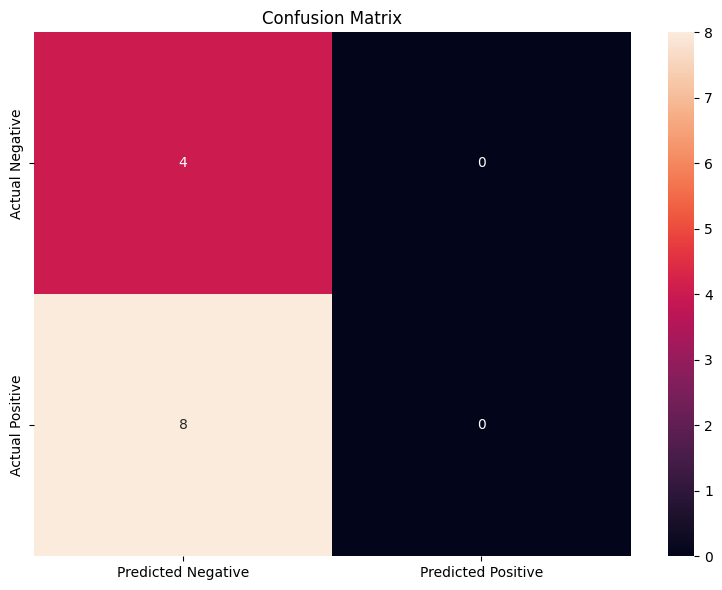

True Positives: 0
False Positives: 0
True Negatives: 4
False Negatives: 8

Sensitivity (Recall): 0.0000
Specificity: 1.0000


In [46]:
# Get duration of the LLM analysis:
duration = timestamp_end_is_photo_analysis - timestamp_start_is_photo_analysis
total_seconds = duration.total_seconds()
print(total_seconds)
store_duration(time_analyses, time_analyses_for_df, analysis_name, duration)

# Store dictionary with LLM responses:
response_dictionaries[analysis_name] = image_descr

# Extract LLM responses from dictionary:
img_ids, is_photo, img_ids_closer_inspection = \
extract_vals_from_response_dict(img_ids, image_descr, keys_list_expected, response_variable)
# Check if the response variable lists has the same length as id list:
print(len(img_ids))
print(len(is_photo))

# Put response variables into data frame: 
predictions = pd.DataFrame({'image_id': img_ids, 
                           prediction_name: is_photo})

# Check for missing values:
print(predictions.isnull().any().any())
print(predictions.isna().any().any())
print(has_missing_comprehensive(predictions))

# Merge label data with the predictions:
labels_results = label_data.merge(predictions, how='inner', on='image_id')
print(labels_results.shape)

# Save labels and predictions in dictionary: 
results_tabular[analysis_name] = labels_results

# Save image list for closer inspection:
images_closer_inspection[analysis_name] = img_ids_closer_inspection

# Calculate sensitivity and specificity for photography predictions and get lists images with positive photography predictions:
subsets_and_metrics = get_classification_subsets_metrics(labels_results, label_name, prediction_name)
positives, negatives, true_positives, true_negatives, \
false_negatives, false_positives, sensitivity, specificity = subsets_and_metrics
print(f'True Positives: {true_positives.shape[0]}')
print(f'False Positives: {false_positives.shape[0]}')
print(f'True Negatives: {true_negatives.shape[0]}')
print(f'False Negatives: {false_negatives.shape[0]}')

# Plot and save convolution matrix: 
cases = (true_positives, false_positives, true_negatives, false_negatives, positives, negatives)
plot_conf_matrix(labels_results, label_name, prediction_name, cases)
save_conf_matrix_tag(labels_results, label_name, prediction_name, cases, analysis_name)

## Identify non-photo images with intuitive prompt:

### Set parameters:

In [47]:

analysis_name = 'is_photo_intuitive_struct_minicpm'
create_analysis_prompt = create_analysis_prompt_intuitive

label_name = 'is_photo'
prediction_name = 'is_photo_pred'
keys_list_expected = ['image_is_photography', 'additional_comments']
response_variable = 'image_is_photography'

### Run LLM image analysis:

In [48]:
timestamp_start_is_photo_analysis, timestamp_end_is_photo_analysis, image_descr = analyse_giub_img_dir_llm(jpg_data_path)



/storage/homefs/sh98e089/test_LLM_prompt_experiments/data_jpg/BernerOberland008.jpg
{'image_is_photography': True, 'additional_comments': 'The image appears to be a black and white photograph of a street scene, likely taken in the early 20th century. The presence of cobblestone streets, old buildings, and people dressed in period clothing suggests that the image is a historical photograph.'}


/storage/homefs/sh98e089/test_LLM_prompt_experiments/data_jpg/BernerOberland015.jpg
{'image_is_photography': True, 'additional_comments': ''}


/storage/homefs/sh98e089/test_LLM_prompt_experiments/data_jpg/BernerOberland081.jpg
{'image_is_photography': False, 'additional_comments': 'The image appears to be a map or a document, possibly an old map or a historical document, given the presence of text and symbols that resemble those found on maps or documents from the past.'}


/storage/homefs/sh98e089/test_LLM_prompt_experiments/data_jpg/BernerOberland035.jpg
{'image_is_photography': True, 'addit

### Extract and store results:

45.733962
12
12
False
False
False
(12, 6)
sensitivity:
1.0
specificity:
1.0
True Positives: 8
False Positives: 0
True Negatives: 4
False Negatives: 0
Confusion Matrix:


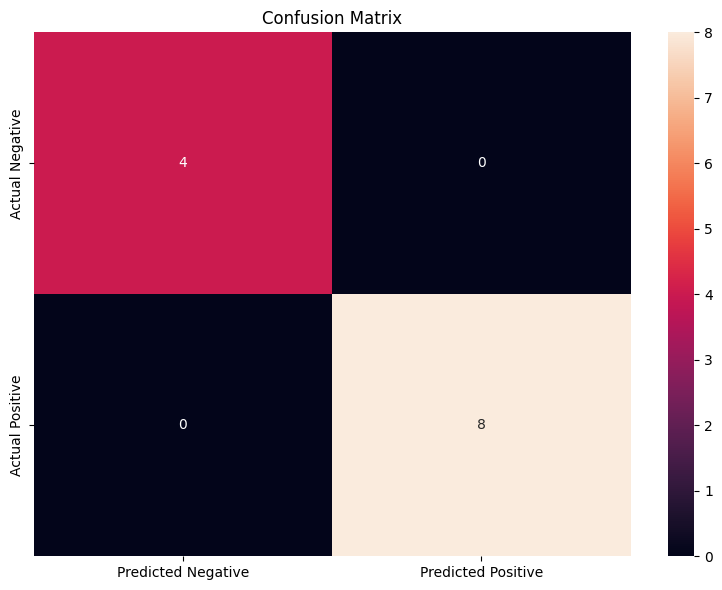

True Positives: 8
False Positives: 0
True Negatives: 4
False Negatives: 0

Sensitivity (Recall): 1.0000
Specificity: 1.0000


In [49]:
# Get duration of the LLM analysis:
duration = timestamp_end_is_photo_analysis - timestamp_start_is_photo_analysis
total_seconds = duration.total_seconds()
print(total_seconds)
store_duration(time_analyses, time_analyses_for_df, analysis_name, duration)

# Store dictionary with LLM responses:
response_dictionaries[analysis_name] = image_descr

# Extract LLM responses from dictionary:
img_ids, is_photo, img_ids_closer_inspection = \
extract_vals_from_response_dict(img_ids, image_descr, keys_list_expected, response_variable)
# Check if the response variable lists has the same length as id list:
print(len(img_ids))
print(len(is_photo))

# Put response variables into data frame: 
predictions = pd.DataFrame({'image_id': img_ids, 
                           prediction_name: is_photo})

# Check for missing values:
print(predictions.isnull().any().any())
print(predictions.isna().any().any())
print(has_missing_comprehensive(predictions))

# Merge label data with the predictions:
labels_results = label_data.merge(predictions, how='inner', on='image_id')
print(labels_results.shape)

# Save labels and predictions in dictionary: 
results_tabular[analysis_name] = labels_results

# Save image list for closer inspection:
images_closer_inspection[analysis_name] = img_ids_closer_inspection

# Calculate sensitivity and specificity for photography predictions and get lists images with positive photography predictions:
subsets_and_metrics = get_classification_subsets_metrics(labels_results, label_name, prediction_name)
positives, negatives, true_positives, true_negatives, \
false_negatives, false_positives, sensitivity, specificity = subsets_and_metrics
print(f'True Positives: {true_positives.shape[0]}')
print(f'False Positives: {false_positives.shape[0]}')
print(f'True Negatives: {true_negatives.shape[0]}')
print(f'False Negatives: {false_negatives.shape[0]}')

# Plot and save convolution matrix: 
cases = (true_positives, false_positives, true_negatives, false_negatives, positives, negatives)
plot_conf_matrix(labels_results, label_name, prediction_name, cases)
save_conf_matrix_tag(labels_results, label_name, prediction_name, cases, analysis_name)

## Identify non-photo images with alternatives prompt:

### Set parameters:

In [50]:

analysis_name = 'is_photo_alternatives_struct_minicpm'
create_analysis_prompt = create_analysis_prompt_alternatives

label_name = 'is_photo'
prediction_name = 'is_photo_pred'
keys_list_expected = ['image_is_photography', 'additional_comments']
response_variable = 'image_is_photography'

### Run LLM image analysis:

In [51]:
timestamp_start_is_photo_analysis, timestamp_end_is_photo_analysis, image_descr = analyse_giub_img_dir_llm(jpg_data_path)



/storage/homefs/sh98e089/test_LLM_prompt_experiments/data_jpg/BernerOberland008.jpg
{'image_is_photography': True, 'additional_comments': 'The image appears to be a black and white photograph of a street scene, likely taken in the early 20th century. The presence of cobblestone streets, old buildings, and horse-drawn carriages suggests a historical setting. The image has a nostalgic quality to it, with a sense of timelessness that is characteristic of old photographs.'}


/storage/homefs/sh98e089/test_LLM_prompt_experiments/data_jpg/BernerOberland015.jpg
{'image_is_photography': True, 'additional_comments': 'The image appears to be a vintage photograph of a street scene, likely taken in the early 20th century. The presence of people, buildings, and vehicles suggests that it is a real-world scene rather than a map, painting, drawing, scheme, or statistics figure.'}


/storage/homefs/sh98e089/test_LLM_prompt_experiments/data_jpg/BernerOberland081.jpg
{'image_is_photography': False, 'ad

### Extract and store results:

50.833423
12
12
False
False
False
(12, 6)
sensitivity:
1.0
specificity:
1.0
True Positives: 8
False Positives: 0
True Negatives: 4
False Negatives: 0
Confusion Matrix:


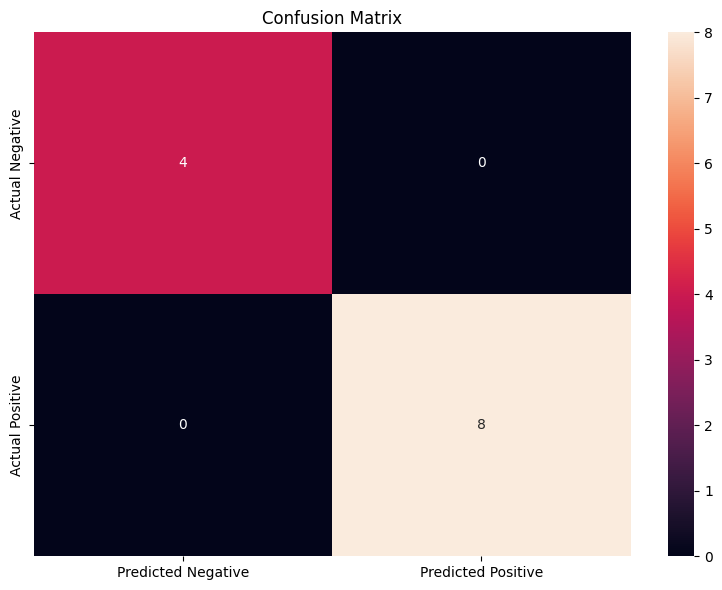

True Positives: 8
False Positives: 0
True Negatives: 4
False Negatives: 0

Sensitivity (Recall): 1.0000
Specificity: 1.0000


In [52]:
# Get duration of the LLM analysis:
duration = timestamp_end_is_photo_analysis - timestamp_start_is_photo_analysis
total_seconds = duration.total_seconds()
print(total_seconds)
store_duration(time_analyses, time_analyses_for_df, analysis_name, duration)

# Store dictionary with LLM responses:
response_dictionaries[analysis_name] = image_descr

# Extract LLM responses from dictionary:
img_ids, is_photo, img_ids_closer_inspection = \
extract_vals_from_response_dict(img_ids, image_descr, keys_list_expected, response_variable)
# Check if the response variable lists has the same length as id list:
print(len(img_ids))
print(len(is_photo))

# Put response variables into data frame: 
predictions = pd.DataFrame({'image_id': img_ids, 
                           prediction_name: is_photo})

# Check for missing values:
print(predictions.isnull().any().any())
print(predictions.isna().any().any())
print(has_missing_comprehensive(predictions))

# Merge label data with the predictions:
labels_results = label_data.merge(predictions, how='inner', on='image_id')
print(labels_results.shape)

# Save labels and predictions in dictionary: 
results_tabular[analysis_name] = labels_results

# Save image list for closer inspection:
images_closer_inspection[analysis_name] = img_ids_closer_inspection

# Calculate sensitivity and specificity for photography predictions and get lists images with positive photography predictions:
subsets_and_metrics = get_classification_subsets_metrics(labels_results, label_name, prediction_name)
positives, negatives, true_positives, true_negatives, \
false_negatives, false_positives, sensitivity, specificity = subsets_and_metrics
print(f'True Positives: {true_positives.shape[0]}')
print(f'False Positives: {false_positives.shape[0]}')
print(f'True Negatives: {true_negatives.shape[0]}')
print(f'False Negatives: {false_negatives.shape[0]}')

# Plot and save convolution matrix: 
cases = (true_positives, false_positives, true_negatives, false_negatives, positives, negatives)
plot_conf_matrix(labels_results, label_name, prediction_name, cases)
save_conf_matrix_tag(labels_results, label_name, prediction_name, cases, analysis_name)

## Save response dictionary:

In [53]:

# Define file name: 
date = str(timestamp_end_is_photo_analysis).split('.')[0][0:10]
filename = 'results_prompt_exp_struct_minicpm_' + date + '.pkl'

# Save dictionary with LLM responses:
img_analysis_output_path = os.path.join(data_path, filename)
with open(img_analysis_output_path, 'wb') as f:
   pickle.dump(response_dictionaries, f)

# Reload saved dictionary to check if saving worked:
with open(img_analysis_output_path, 'rb') as f:
   reloaded_image_descr = pickle.load(f)

# Check if original and reloaded dictionary are the same:
print(len(image_descr))
print(type(image_descr))
print(type(reloaded_image_descr))
print(len(reloaded_image_descr))

print(image_descr.keys() == reloaded_image_descr.keys())

12
<class 'dict'>
<class 'dict'>
4
False


## Save labels and results:

In [54]:

# Define file name: 
current_timestamp = pd.Timestamp.now()
current_date_time = current_timestamp.strftime('%Y-%m-%d %H:%M')
results_file_name = 'results_table_prompt_exp_struct_minicpm_' + current_date_time + '.pkl'

# Save dictionary with LLM responses:
results_tabular_output_path = os.path.join(data_path, results_file_name)
with open(results_tabular_output_path, 'wb') as f:
   pickle.dump(results_tabular, f)

# Reload saved dictionary to check if saving worked:
with open(results_tabular_output_path, 'rb') as f:
   reloaded_results_tabular = pickle.load(f)

# Check if original and reloaded dictionary are the same:
print(len(results_tabular))
print(type(results_tabular))
print(type(reloaded_results_tabular))
print(len(reloaded_results_tabular))

print(results_tabular.keys() == reloaded_results_tabular.keys())

4
<class 'dict'>
<class 'dict'>
4
True


## Calculate duration of analysis overall:

In [55]:
timestamp_end_workflow = pd.Timestamp.now()
timestamp_end_workflow

Timestamp('2025-09-25 18:43:40.635349')

In [56]:
duration = timestamp_end_workflow - timestamp_start_workflow
total_seconds = duration.total_seconds()
store_duration(time_analyses, time_analyses_for_df, analysis_name, duration)
print(f"Analysis took: {duration}")
print(f"Analysis took: {total_seconds:.2f} seconds")
print(f"Analysis took: {total_seconds/60:.2f} minutes")

Analysis took: 0 days 00:04:06.140622
Analysis took: 246.14 seconds
Analysis took: 4.10 minutes


## Save time analyses: 

In [57]:

# Define file name: 
current_date_time = current_timestamp.strftime('%Y-%m-%d %H:%M')
time_analyses_file_name = 'times_prompt_exp_struct_minicpm_' + current_date_time + '.pkl'

# Save dictionary with LLM responses:
time_analyses_output_path = os.path.join(data_path, time_analyses_file_name)
with open(time_analyses_output_path, 'wb') as f:
   pickle.dump(time_analyses, f)

# Reload saved dictionary to check if saving worked:
with open(time_analyses_output_path, 'rb') as f:
   reloaded_time_analyses = pickle.load(f)

# Check if original and reloaded dictionary are the same:
print(len(time_analyses))
print(type(time_analyses))
print(type(reloaded_time_analyses))
print(len(reloaded_time_analyses))

print(time_analyses.keys() == reloaded_time_analyses.keys())

4
<class 'dict'>
<class 'dict'>
4
True


In [58]:

# Define file name: 
current_date_time = current_timestamp.strftime('%Y-%m-%d %H:%M')
time_analyses_df_file_name = 'times_df_prompt_exp_struct_minicpm_' + current_date_time + '.pkl'

# Save dictionary with LLM responses:
time_analyses_df_output_path = os.path.join(data_path, time_analyses_df_file_name)
with open(time_analyses_df_output_path, 'wb') as f:
   pickle.dump(time_analyses_for_df, f)

# Reload saved dictionary to check if saving worked:
with open(time_analyses_df_output_path, 'rb') as f:
   reloaded_time_analyses_for_df = pickle.load(f)

# Check if original and reloaded dictionary are the same:
print(len(time_analyses_for_df))
print(type(time_analyses_for_df))
print(type(reloaded_time_analyses_for_df))
print(len(reloaded_time_analyses_for_df))

print(time_analyses_for_df.keys() == reloaded_time_analyses_for_df.keys())

6
<class 'dict'>
<class 'dict'>
6
True


In [59]:
time_analyses

{'is_photo_basic_struct_minicpm': {'duration_str': 'Analysis took: 0 days 00:01:26.544578',
  'duration_seconds': 86.544578,
  'duration_seconds_str': 'Analysis took: 86.54 seconds',
  'duration_minutes': 1.4424096333333334,
  'duration_minutes_str': 'Analysis took: 1.44 minutes',
  'time_stamp_start': Timestamp('2025-09-25 18:39:35.174907'),
  'time_stamp_end': Timestamp('2025-09-25 18:41:01.719485')},
 'is_photo_precise_struct_minicpm': {'duration_str': 'Analysis took: 0 days 00:00:59.998170',
  'duration_seconds': 59.99817,
  'duration_seconds_str': 'Analysis took: 60.00 seconds',
  'duration_minutes': 0.9999695000000001,
  'duration_minutes_str': 'Analysis took: 1.00 minutes',
  'time_stamp_start': Timestamp('2025-09-25 18:41:03.431160'),
  'time_stamp_end': Timestamp('2025-09-25 18:42:03.429330')},
 'is_photo_intuitive_struct_minicpm': {'duration_str': 'Analysis took: 0 days 00:00:45.733962',
  'duration_seconds': 45.733962,
  'duration_seconds_str': 'Analysis took: 45.73 seconds'